In [21]:
import sys
import os

# set notebook working directory to project root
project_root = os.path.abspath("..")  # or specify full path
sys.path.append(project_root)

print("Added to PYTHONPATH:", project_root)


Added to PYTHONPATH: c:\Users\Dioporco\Desktop\Cognitive Science UOS\4-D\SINDy_Autoencoder


In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from src.model import SINDy_Autoencoder
from src.evaluation import (
    reconstruction_error,
    evaluate_latent_dynamics,
    rollout_from_x0,
    evaluate_rollout_dataset,
    residuals_one_step,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [23]:
checkpoint_path = "../sindyae_full_checkpoint.pt"  # change if needed

ckpt = torch.load(checkpoint_path, map_location=device)
hp = ckpt["hyperparams"]

print("Loaded hyperparameters:", hp)

model = SINDy_Autoencoder(
    x_dim=hp["x_dim"],
    z_dim=hp["z_dim"],
    enc_hidden=tuple(hp["enc_hidden"]),
    dec_hidden=tuple(hp["dec_hidden"]),
    poly_order=hp["poly_order"],
    include_bias=hp["include_bias"],
).to(device)

model.load_state_dict(ckpt["state_dict"])
model.eval()

print("Model loaded and set to eval().")


Loaded hyperparameters: {'x_dim': 9, 'z_dim': 3, 'enc_hidden': (128, 64), 'dec_hidden': (64, 128), 'poly_order': 3, 'include_bias': True}
Model loaded and set to eval().


In [24]:
import os
import json

# Example: adapt to your actual paths
data_dir = "../dataset_2022_silverstone_ham"

X = np.load(os.path.join(data_dir, "X.npy"))        # shape [N_traj, T, x_dim] or [T, x_dim]
t = np.load(os.path.join(data_dir, "t.npy"))        # time vector
with open(os.path.join(data_dir, "metadata.json"), "r") as f:
    meta = json.load(f)

print("X shape:", X.shape)
print("t shape:", t.shape)
print("metadata:", meta)

# If X is [T, x_dim], wrap into a single trajectory [1, T, x_dim]
if X.ndim == 2:
    X = X[None, :, :]

# Simple train/test split (adapt as you like)
split = int(0.8 * X.shape[1])
X_train = X[:, :split, :]
X_test  = X[:, split:, :]

dt = float(meta.get("dt", t[1] - t[0]))  # if dt is in metadata, otherwise infer
print("dt:", dt)
print("X_train:", X_train.shape, "X_test:", X_test.shape)




X shape: (4526, 9)
t shape: (4526,)
metadata: {'year': 2022, 'gp': 'Silverstone', 'session': 'R', 'driver': 'HAM', 'dt': 0.02, 'all_laps': False, 'min_lap_time': 0.0, 'n_samples': 4526, 'n_state': 9, 'n_laps_used': 1, 'state_cols': ['Distance', 'Speed', 'Throttle', 'Brake', 'nGear', 'RPM', 'X', 'Y', 'Z']}
dt: 0.02
X_train: (1, 3620, 9) X_test: (1, 906, 9)


In [25]:
print("Min:", X.min(), "Max:", X.max())
print("Mean:", X.mean(), "Std:", X.std())


Min: -3.459879102563587 Max: 2.5771586448373602
Mean: 2.9360866421942373e-15 Std: 0.9999999999999903


In [26]:
# 1) Autoencoder reconstruction quality
recon_stats = reconstruction_error(model, X_test, batch_size=64, device=device)
print("=== Reconstruction ===")
print("MSE:", recon_stats["mse_recon"])
print("R2 mean:", recon_stats["r2_recon_mean"])
print("R2 per dim:", recon_stats["r2_recon_per_dim"])

# 2) Latent dynamics consistency (zdot_true vs zdot_pred)
latent_stats = evaluate_latent_dynamics(
    model,
    X_test,
    dt=dt,
    diff_method="finite-diff",   # adapt if you used another method in training
    diff_kwargs={},         # e.g. {"order": 2} if needed
    batch_size=64,
    device=device,
)

print("\n=== Latent dynamics ===")
print("MSE dz:", latent_stats["mse_dz"])
print("R2 dz mean:", latent_stats["r2_dz_mean"])
print("R2 dz per dim:", latent_stats["r2_dz_per_dim"])


=== Reconstruction ===
MSE: 0.03167584910988808
R2 mean: 0.942621111869812
R2 per dim: [0.93302375 0.97077817 0.9513479  0.9677067  0.9625673  0.8439496
 0.9761198  0.91349626 0.9646    ]

=== Latent dynamics ===
MSE dz: 0.31969764828681946
R2 dz mean: -0.034236688166856766
R2 dz per dim: [ 0.24690455 -0.46346593  0.11385131]


In [27]:
horizons = (1, 5, 10, 20, 50)

rollout_stats = evaluate_rollout_dataset(
    model,
    X_test,
    dt=dt,
    horizons=horizons,
    device=device,
    integrator="rk4",   # or "rk4" if you want more accurate integration
)

print("=== Rollout metrics ===")
print("Horizons:", rollout_stats["horizons"])
print("MSE rollout:", rollout_stats["mse_rollout"])
print("R2 rollout mean:", rollout_stats["r2_rollout_mean"])


=== Rollout metrics ===
Horizons: [1, 5, 10, 20, 50]
MSE rollout: {1: 0.0, 5: 0.01603688858449459, 10: 0.017712535336613655, 20: 0.01823708601295948, 50: 0.02208549901843071}
R2 rollout mean: {1: 1.0, 5: -37658009600.0, 10: -91757101056.0, 20: -182951313408.0, 50: -616346681344.0}


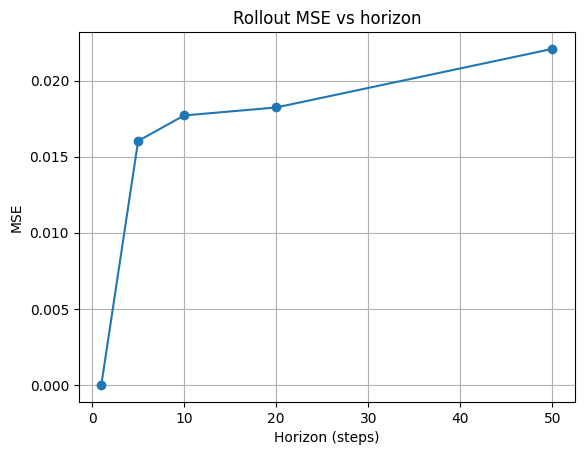

In [28]:
plt.figure()
hs = rollout_stats["horizons"]
mse_vals = [rollout_stats["mse_rollout"][h] for h in hs]
plt.plot(hs, mse_vals, marker="o")
plt.xlabel("Horizon (steps)")
plt.ylabel("MSE")
plt.title("Rollout MSE vs horizon")
plt.grid(True)
plt.show()


Residuals shape: torch.Size([1, 905, 9])


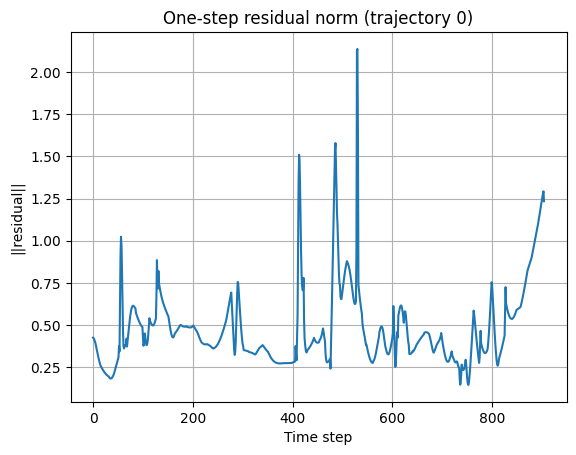

In [29]:
res = residuals_one_step(model, X_test, dt=dt, device=device)
print("Residuals shape:", res.shape)  # [N_traj, T-1, x_dim]

# Example: plot residuals norm over time for the first trajectory
res_norm = np.linalg.norm(res[0].numpy(), axis=-1)

plt.figure()
plt.plot(res_norm)
plt.xlabel("Time step")
plt.ylabel("||residual||")
plt.title("One-step residual norm (trajectory 0)")
plt.grid(True)
plt.show()


(1, 906, 9)


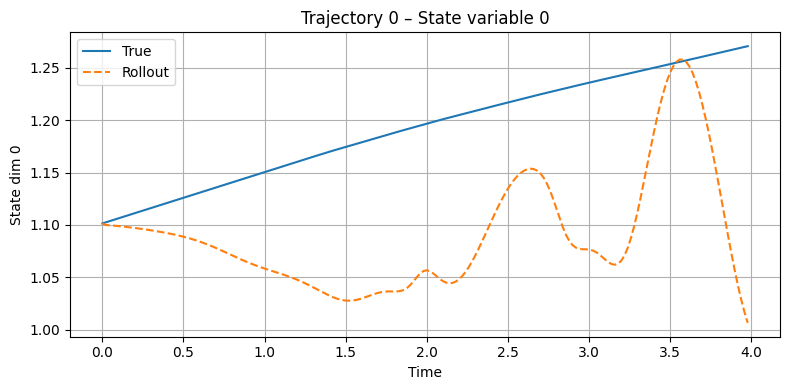

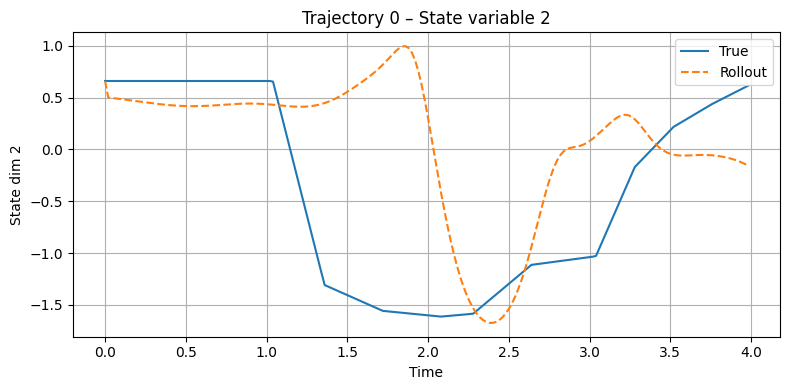

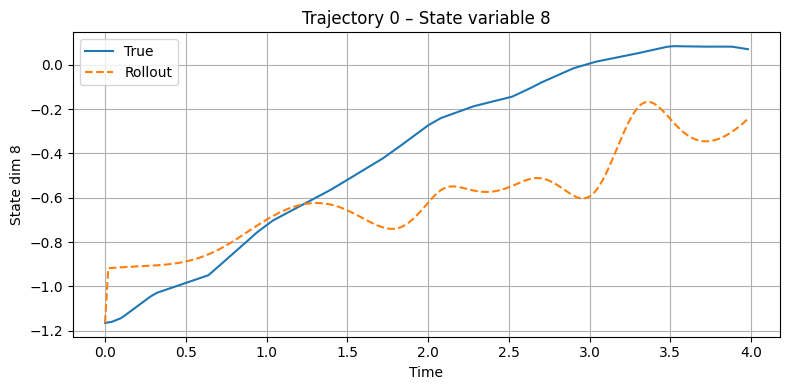

Trajectory 4 is out of range (N_traj=1)
Trajectory 4 is out of range (N_traj=1)


In [48]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Select device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Choose the evaluation dataset
X_eval = X_test if "X_test" in globals() else X

# Convert to numpy for plotting
if isinstance(X_eval, torch.Tensor):
    X_eval_np = X_eval.cpu().numpy()
else:
    X_eval_np = np.asarray(X_eval, dtype=float)

print(X_eval_np.shape)
N_traj, T, x_dim = X_eval_np.shape

# --- Parameters to customize ---
traj_indices = [0, 4, 4]     # which trajectories to visualize
state_dims   = [0, 2, 8]     # which state variables to plot
n_steps      = min(200, T)   # rollout horizon
integrator   = "rk4"         # "euler" or "rk4"
# --------------------------------

# Time axis
t_axis = np.arange(n_steps) * dt

for traj in traj_indices:
    if traj >= N_traj:
        print(f"Trajectory {traj} is out of range (N_traj={N_traj})")
        continue

    # True trajectory
    x_true = X_eval_np[traj, :n_steps, :]   # shape [n_steps, x_dim]
    x0 = x_true[0]                          # initial state

    # Convert and run rollout
    x0_torch = torch.from_numpy(x0).float().to(device)
    x_pred_rollout, _ = rollout_from_x0(
        model,
        x0_torch,
        n_steps=n_steps,
        dt=dt,
        device=device,
        integrator=integrator,
    )
    x_pred = x_pred_rollout[0].cpu().numpy()   # [n_steps, x_dim]

    # Plot selected state dimensions
    for d in state_dims:
        if d >= x_dim:
            print(f"State dim {d} is out of range (x_dim={x_dim})")
            continue

        plt.figure(figsize=(8, 4))
        plt.plot(t_axis, x_true[:, d], label="True")
        plt.plot(t_axis, x_pred[:, d], "--", label="Rollout")
        plt.xlabel("Time")
        plt.ylabel(f"State dim {d}")
        plt.title(f"Trajectory {traj} – State variable {d}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
